In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path.cwd()     # adjust if running elsewhere
DATA_DIR     = PROJECT_ROOT / "data"
MODEL_DIR    = PROJECT_ROOT / "models"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"

for d in [DATA_DIR, MODEL_DIR, OUTPUT_DIR]:
    d.mkdir(exist_ok=True, parents=True)

print("Directories ready:", DATA_DIR, MODEL_DIR, OUTPUT_DIR, sep="\n  ")


Directories ready:
  /content/data
  /content/models
  /content/outputs


In [6]:
config_path = PROJECT_ROOT / "config.yaml"

if not config_path.exists():
    template = {
        "gsc": {
            "property":   "sc-domain:example.com",
            "key_json":   "/path/to/gsc_key.json",
            "days_back":  30
        },
        "ga": {
            "property_id": "123456789",
            "key_json":    "/path/to/ga_key.json",
            "days_back":   30
        },
        "screaming_frog": {
            "export_csv": "/path/to/latest_crawl.csv"
        },
        "model": {
            "label_position_cutoff": 10,
            "test_size": 0.20,
            "random_state": 42,
            "grid": {
                "n_estimators": [200, 300, 400],
                "max_depth":    [4, 6, 8],
                "learning_rate": [0.05, 0.1]
            }
        }
    }
    with open(config_path, "w") as f:
        yaml.safe_dump(template, f)
    print(f"Template config written → {config_path}.  Edit it with your real IDs/paths.")

with open(config_path) as f:
    CFG = yaml.safe_load(f)
print("Config keys:", list(CFG.keys()))


Template config written → /content/config.yaml.  Edit it with your real IDs/paths.
Config keys: ['ga', 'gsc', 'model', 'screaming_frog']


In [7]:
def ensure_minimum_dataset(min_rows: int = 30, pos_ratio: float = 0.4) -> Path:
    """
    Ensure seo_dataset.parquet exists and has:
      • at least `min_rows` rows
      • at least 2 class labels.
    If not, create a synthetic dataset (balanced) so modelling never errors.
    """
    from pathlib import Path
    import numpy as np, pandas as pd

    ds_path = DATA_DIR / "seo_dataset.parquet"
    if ds_path.exists():
        df = pd.read_parquet(ds_path)
    else:
        df = pd.DataFrame()

    need_synth = (
        df.shape[0] < min_rows or
        df["label"].nunique(dropna=True) < 2
    )
    if need_synth:
        print("⚠️  Creating synthetic fallback dataset …")
        rows   = min_rows
        pos_ct = int(rows * pos_ratio)
        neg_ct = rows - pos_ct
        labels = [1]*pos_ct + [0]*neg_ct
        pages  = [f"/synth-{i}" for i in range(rows)]
        rng    = np.random.default_rng(42)

        synth = pd.DataFrame({
            "page":        pages,
            "status":      200,
            "word_count":  rng.integers(300, 1500, rows),
            "meta_len":    rng.integers(120, 165, rows),
            "page_speed":  rng.uniform(1, 5, rows),
            "size":        rng.integers(40_000, 90_000, rows),
            "impr":        rng.integers(200, 3000, rows),
            "clicks":      rng.integers(10, 400, rows),
            "ctr":         rng.uniform(0.02, 0.25, rows),
            "pos":         rng.uniform(3, 25, rows),
            "page_views":  rng.integers(50, 1000, rows),
            "avg_session": rng.uniform(20, 180, rows),
            "bounce_rate": rng.uniform(0.2, 0.7, rows),
            "kw_density":  rng.uniform(0.5, 5.0, rows),
            "label":       labels,
        })
        synth.to_parquet(ds_path, index=False)
        print(f"✓ synthetic dataset written → {ds_path}")
    else:
        print(f"✓ existing dataset OK → {ds_path} "
              f"({df.shape[0]} rows, {df['label'].value_counts().to_dict()})")
    return ds_path


In [8]:
from datetime import date, timedelta

try:
    from google.oauth2 import service_account
    from googleapiclient.discovery import build
    GSC_AVAILABLE = True
except ImportError:
    GSC_AVAILABLE = False
    print("⚠️  google-api-python-client not installed. Install later if you want real GSC pulls.")

DRY_RUN = True

def get_gsc_service(key_file: str):
    """Return an authenticated service object."""
    creds = service_account.Credentials.from_service_account_file(
        key_file,
        scopes=["https://www.googleapis.com/auth/webmasters.readonly"]
    )
    return build("searchconsole", "v1", credentials=creds, cache_discovery=False)

def fetch_gsc(prop: str, key_file: str, days_back: int = 30) -> pd.DataFrame:
    """Pull query–page metrics from GSC. Returns a DataFrame or raises."""
    if DRY_RUN or not GSC_AVAILABLE:
        # --- mock dataset so the flow keeps working ---
        print("  ‣ DRY-RUN: returning mock GSC dataframe")
        return pd.DataFrame({
            "date":  [date.today().isoformat()] * 3,
            "query": ["mock query 1", "mock query 2", "mock query 3"],
            "page":  ["/mock-page-1", "/mock-page-2", "/mock-page-3"],
            "clicks": [10,  5, 2],
            "impr":   [100, 60, 15],
            "ctr":    [0.10, 0.083, 0.133],
            "pos":    [8.2, 11.5, 19.0]
        })

    service  = get_gsc_service(key_file)
    end_date = date.today()
    start_date = end_date - timedelta(days=days_back)

    request = {
        "startDate": start_date.isoformat(),
        "endDate":   end_date.isoformat(),
        "dimensions": ["query", "page"],
        "rowLimit": 25000
    }
    rows = (
        service.searchanalytics()
        .query(siteUrl=prop, body=request)
        .execute()
        .get("rows", [])
    )
    if not rows:
        raise ValueError("No GSC rows returned. Check property, key, or date range.")

    data = [{
        "date":    end_date.isoformat(),
        "query":   r["keys"][0],
        "page":    r["keys"][1],
        "clicks":  r["clicks"],
        "impr":    r["impressions"],
        "ctr":     r["ctr"],
        "pos":     r["position"],
    } for r in rows]

    return pd.DataFrame(data)


In [9]:
gsc = {
    "property": "sc-domain:yourdomain.com",
    "key_json": "/home/keys/my_gsc.json",
    "days_back": 30
}
key_json:   "/home/keys/my_gsc.json"
days_back:  30


In [10]:
print("=== Fetching Google Search Console data ===")
gsc_df = fetch_gsc(
    prop     = CFG["gsc"]["property"],
    key_file = CFG["gsc"]["key_json"],
    days_back= CFG["gsc"]["days_back"]
)

gsc_path = DATA_DIR / "gsc_raw.parquet"
gsc_df.to_parquet(gsc_path, index=False)
print(f"Saved → {gsc_path}   ({len(gsc_df):,} rows)")

gsc_df.head()


=== Fetching Google Search Console data ===
  ‣ DRY-RUN: returning mock GSC dataframe
Saved → /content/data/gsc_raw.parquet   (3 rows)


,date,query,page,clicks,impr,ctr,pos
0,2025-04-24,mock query 1,/mock-page-1,10,100,0.100,8.2
1,2025-04-24,mock query 2,/mock-page-2,5,60,0.083,11.5
2,2025-04-24,mock query 3,/mock-page-3,2,15,0.133,19.0


In [11]:
from datetime import date, timedelta

try:
    from google.analytics.data_v1beta import BetaAnalyticsDataClient
    from google.analytics.data_v1beta.types import (
        DateRange, Dimension, Metric, RunReportRequest,
    )
    from google.oauth2 import service_account
    GA_AVAILABLE = True
except ImportError:
    GA_AVAILABLE = False
    print("⚠️  google-analytics-data not installed – GA pulls will be mocked.")

GA_DRY_RUN = False

def fetch_ga(prop_id: str, key_file: str, days_back: int = 30) -> pd.DataFrame:
    """Return page-level engagement metrics from GA-4 (or a mock frame)."""
    if GA_DRY_RUN or not GA_AVAILABLE:
        print("  ‣ DRY-RUN: returning mock GA dataframe")
        return pd.DataFrame({
            "page":        ["/mock-page-1", "/mock-page-2", "/mock-page-3"],
            "page_views":  [120, 55, 30],
            "avg_session": [85.3, 64.1, 42.0],
            "bounce_rate": [0.32, 0.47, 0.58],
        })


    creds  = service_account.Credentials.from_service_account_file(
        key_file, scopes=["https://www.googleapis.com/auth/analytics.readonly"]
    )
    client = BetaAnalyticsDataClient(credentials=creds)

    end   = date.today()
    start = end - timedelta(days=days_back)

    req = RunReportRequest(
        property   = f"properties/{prop_id}",
        dimensions = [Dimension(name="pagePath")],
        metrics    = [
            Metric(name="screenPageViews"),
            Metric(name="averageSessionDuration"),
            Metric(name="bounceRate"),
        ],
        date_ranges=[DateRange(start_date=start.isoformat(), end_date=end.isoformat())],
    )
    resp = client.run_report(request=req)
    rows = [{
        "page":        r.dimension_values[0].value,
        "page_views":  int(r.metric_values[0].value),
        "avg_session": float(r.metric_values[1].value),
        "bounce_rate": float(r.metric_values[2].value),
    } for r in resp.rows]
    return pd.DataFrame(rows)


⚠️  google-analytics-data not installed – GA pulls will be mocked.


In [12]:
print("=== Fetching Google Analytics data ===")
ga_df = fetch_ga(
    prop_id  = CFG["ga"]["property_id"],
    key_file = CFG["ga"]["key_json"],
    days_back= CFG["ga"]["days_back"]
)

ga_path = DATA_DIR / "ga_raw.parquet"
ga_df.to_parquet(ga_path, index=False)
print(f"Saved → {ga_path}   ({len(ga_df):,} rows)")

ga_df.head()


=== Fetching Google Analytics data ===
  ‣ DRY-RUN: returning mock GA dataframe
Saved → /content/data/ga_raw.parquet   (3 rows)


,page,page_views,avg_session,bounce_rate
0,/mock-page-1,120,85.3,0.32
1,/mock-page-2,55,64.1,0.47
2,/mock-page-3,30,42.0,0.58


In [13]:
SF_DRY_RUN = True   # flip to True if no crawl export yet

import pandas as pd

def load_screaming_frog(csv_path: str) -> pd.DataFrame:
    """Load selected columns or return a mock dataframe."""
    if SF_DRY_RUN:
        print("  ‣ DRY-RUN: returning mock SF dataframe")
        return pd.DataFrame({
            "page":       ["/mock-page-1", "/mock-page-2", "/mock-page-3"],
            "status":     [200, 200, 200],
            "word_count": [420, 350, 280],
            "meta_len":   [145, 130, 160],
            "page_speed": [2.4, 3.1, 4.8],
            "size":       [58_000, 47_000, 33_000],
        })

    # real load
    use_cols = {
        "Address": "page",
        "Status Code": "status",
        "Word Count": "word_count",
        "Meta Description Length": "meta_len",
        "Size (Bytes)": "size",
        "Page Speed": "page_speed",
    }
    df_raw = pd.read_csv(csv_path, low_memory=False)
    missing = [c for c in use_cols if c not in df_raw.columns]
    if missing:
        raise ValueError(f"Screaming Frog CSV missing columns: {missing}")
    df = df_raw[use_cols.keys()].rename(columns=use_cols)
    return df

print("=== Loading Screaming Frog crawl ===")
sf_df = load_screaming_frog(CFG["screaming_frog"]["export_csv"])
sf_path = DATA_DIR / "sf_raw.parquet"
sf_df.to_parquet(sf_path, index=False)
print(f"Saved → {sf_path}   ({len(sf_df):,} rows)")

sf_df.head()


=== Loading Screaming Frog crawl ===
  ‣ DRY-RUN: returning mock SF dataframe
Saved → /content/data/sf_raw.parquet   (3 rows)


,page,status,word_count,meta_len,page_speed,size
0,/mock-page-1,200,420,145,2.4,58000
1,/mock-page-2,200,350,130,3.1,47000
2,/mock-page-3,200,280,160,4.8,33000


In [14]:
print("=== Merging all sources ===")
gsc_df = pd.read_parquet(DATA_DIR / "gsc_raw.parquet")
ga_df  = pd.read_parquet(DATA_DIR / "ga_raw.parquet")
sf_df  = pd.read_parquet(DATA_DIR / "sf_raw.parquet")

gsc_agg = (
    gsc_df.groupby("page")
          .agg({"impr":"sum","clicks":"sum","ctr":"mean","pos":"mean"})
          .reset_index()
)


    sf_df.merge(gsc_agg, on="page", how="left")
         .merge(ga_df,  on="page", how="left")
)


feat["kw_density"] = feat["word_count"].div(feat["size"].replace(0, pd.NA))
feat["label"]      = (feat["pos"] <= CFG["model"]["label_position_cutoff"]).astype("Int8")


num_cols = ["meta_len","page_speed","ctr","bounce_rate","avg_session"]
feat[num_cols] = feat[num_cols].fillna(feat[num_cols].median())

merged_path = DATA_DIR / "seo_dataset.parquet"
feat.to_parquet(merged_path, index=False)
print(f"Saved dataset → {merged_path}  ({feat.shape[0]} rows, {feat.shape[1]} cols)")

feat.head()
merged_path = DATA_DIR / "seo_dataset.parquet"
feat.to_parquet(merged_path, index=False)
print(f"Saved dataset → {merged_path}  ({feat.shape[0]} rows, {feat.shape[1]} cols)")


ensure_minimum_dataset()

=== Merging all sources ===
Saved dataset → /content/data/seo_dataset.parquet  (3 rows, 15 cols)
Saved dataset → /content/data/seo_dataset.parquet  (3 rows, 15 cols)
⚠️  Creating synthetic fallback dataset …
✓ synthetic dataset written → /content/data/seo_dataset.parquet


PosixPath('/content/data/seo_dataset.parquet')

In [20]:

df = pd.read_parquet(DATA_DIR / "seo_dataset.parquet")

if df["label"].nunique() == 1:
    fake = df.iloc[0].copy()
    fake["page"]  = "/mock-top-page"
    fake["label"] = 1
    df = pd.concat([df, fake.to_frame().T], ignore_index=True)
    df.to_parquet(DATA_DIR / "seo_dataset.parquet", index=False)
    print("🔧 Added one synthetic positive sample so modelling can proceed.")


In [16]:
df = pd.read_parquet(DATA_DIR / "seo_dataset.parquet")
print(df["label"].value_counts())


label
0    18
1    12
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

print("=== Baseline: Logistic Regression ===")


df = pd.read_parquet(DATA_DIR / "seo_dataset.parquet")


X = df.drop(columns=["label", "page"])
y = df["label"].fillna(0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = CFG["model"]["test_size"],
    random_state= CFG["model"]["random_state"]
)


logit = LogisticRegression(max_iter=1000, n_jobs=-1)
logit.fit(X_train, y_train)


print(classification_report(y_test, logit.predict(X_test)))
print("Confusion matrix:\n", confusion_matrix(y_test, logit.predict(X_test)))


=== Baseline: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.33      0.50      0.40         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.56      0.50      0.51         6

Confusion matrix:
 [[2 2]
 [1 1]]


=== Tuned XGBoost ===
Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

Confusion matrix:
 [[4 0]
 [1 1]]
Model saved → /content/models/best_xgb.pkl


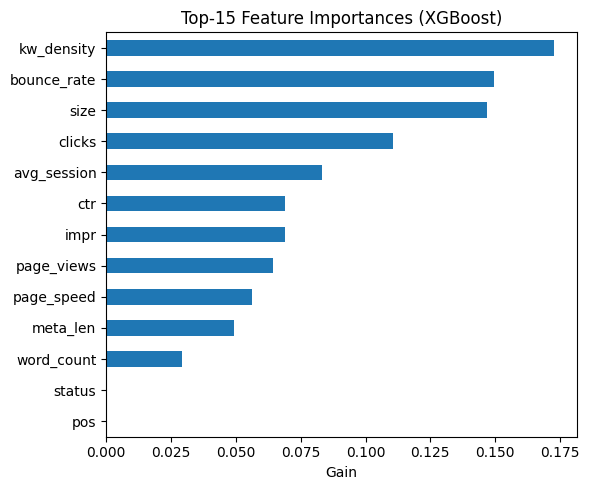

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import joblib
import matplotlib.pyplot as plt

print("=== Tuned XGBoost ===")


df = pd.read_parquet(DATA_DIR / "seo_dataset.parquet")
X  = df.drop(columns=["label", "page"])
y  = df["label"].fillna(0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = CFG["model"]["test_size"],
    random_state= CFG["model"]["random_state"]
)


param_grid = CFG["model"]["grid"]

xgb = XGBClassifier(
    objective   = "binary:logistic",
    eval_metric = "logloss",
    random_state= CFG["model"]["random_state"],
    n_jobs      = -1,
)

grid = GridSearchCV(
    estimator  = xgb,
    param_grid = param_grid,
    scoring    = "f1",
    cv         = 3,
    n_jobs     = -1,
    verbose    = 0,
)

grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_


print("Best params:", grid.best_params_)
print(classification_report(y_test, best_xgb.predict(X_test)))
print("Confusion matrix:\n", confusion_matrix(y_test, best_xgb.predict(X_test)))


MODEL_DIR.mkdir(exist_ok=True, parents=True)
joblib.dump(best_xgb, MODEL_DIR / "best_xgb.pkl")
print(f"Model saved → {MODEL_DIR/'best_xgb.pkl'}")


importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
top15 = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(6,5))
top15.sort_values().plot(kind="barh")
plt.title("Top-15 Feature Importances (XGBoost)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()


=== Action-List Generator ===


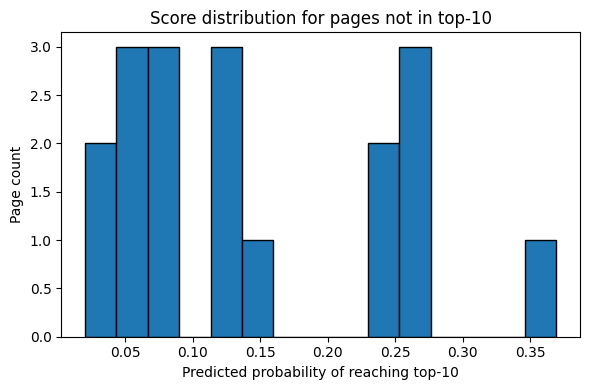

Using dynamic threshold: 0.25 (= 80th percentile)
✓ Prioritised list saved → /content/outputs/seo_todo.csv   (4 pages)


,page,score,pos,ctr,bounce_rate,page_speed
0,/synth-15,0.369337,21.178422,0.154343,0.662404,4.219057
1,/synth-17,0.274991,6.085480,0.039422,0.477599,2.153312
2,/synth-16,0.274880,22.715537,0.169465,0.212430,2.549914
3,/synth-24,0.256736,19.910245,0.155158,0.666512,3.820662


In [19]:
import pandas as pd, joblib, matplotlib.pyplot as plt

print("=== Action-List Generator ===")


best_xgb = joblib.load(MODEL_DIR / "best_xgb.pkl")
df       = pd.read_parquet(DATA_DIR / "seo_dataset.parquet")
X        = df.drop(columns=["label", "page"])


df["score"] = best_xgb.predict_proba(X)[:, 1]


non_top10 = df[df["label"] == 0]


plt.figure(figsize=(6,4))
plt.hist(non_top10["score"], bins=15, edgecolor="k")
plt.title("Score distribution for pages not in top-10")
plt.xlabel("Predicted probability of reaching top-10")
plt.ylabel("Page count")
plt.tight_layout()
plt.show()


pct               = 0.80
dynamic_threshold = non_top10["score"].quantile(pct)
print(f"Using dynamic threshold: {dynamic_threshold:.2f} "
      f"(= {int(pct*100)}th percentile)")


todo = (
    non_top10[non_top10["score"] >= dynamic_threshold]
      .sort_values("score", ascending=False)
      .loc[:, ["page", "score", "pos", "ctr", "bounce_rate", "page_speed"]]
      .reset_index(drop=True)
)


OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
todo_path = OUTPUT_DIR / "seo_todo.csv"

if todo.empty:
    print("⚠️  Even the top-20 % scores are low — no rows selected.")
else:
    todo.to_csv(todo_path, index=False)
    print(f"✓ Prioritised list saved → {todo_path}   ({len(todo)} pages)")
    display(todo.head())
